In [1]:
from pstats import count_calls

import cv2
import kagglehub
from fontTools.ufoLib import dataDict
from jedi.inference.recursion import total_function_execution_limit
from keras.src.utils import to_categorical
from win32con import IMAGE_SIZEOF_SYMBOL

# Download latest version
path = kagglehub.dataset_download("ahmedhamada0/brain-tumor-detection")

print("Path to dataset files:", path)

C:\Users\mathe\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 84.0M/84.0M [00:03<00:00, 23.8MB/s]

Extracting files...


Path to dataset files: C:\Users\mathe\.cache\kagglehub\datasets\ahmedhamada0\brain-tumor-detection\versions\12


In [21]:
# Step 1: Import Libraries
import pandas as pd
import seaborn as sns
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


In [24]:
# Step 2: Load and Explore Dataset
# Set the path to your Kaggle dataset directory (replace with your path)
DATA_DIR = r"C:\Users\mathe\.cache\kagglehub\datasets\ahmedhamada0\brain-tumor-detection\versions\12" # Change this path


# Check folders
classes = os.listdir(DATA_DIR)
print("Classes found:", classes)

Classes found: ['Br35H-Mask-RCNN', 'no', 'pred', 'yes']


In [16]:
# step 3: Definet the classes

classes =  ['no','yes']
print("Classes for training:", classes)

Classes for training: ['no', 'yes']


In [25]:
# step 4: Count images in folders

DATA_DIR = r"C:\Users\mathe\.cache\kagglehub\datasets\ahmedhamada0\brain-tumor-detection\versions\12"

categories =  ["yes", "no"]

data = []
labels = []
IMG_SIZE = 150

for category in categories:
    folder = os.path.join(DATA_DIR, category)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            data.append(img)
            labels.append(category)
        except:
            continue

data = np.array(data)
labels = np.array(labels)
print(f"Total images: {len(data)} | Yes: {np.sum(labels=='yes')} | No: {np.sum(labels=='no')}")


Total images: 3000 | Yes: 1500 | No: 1500


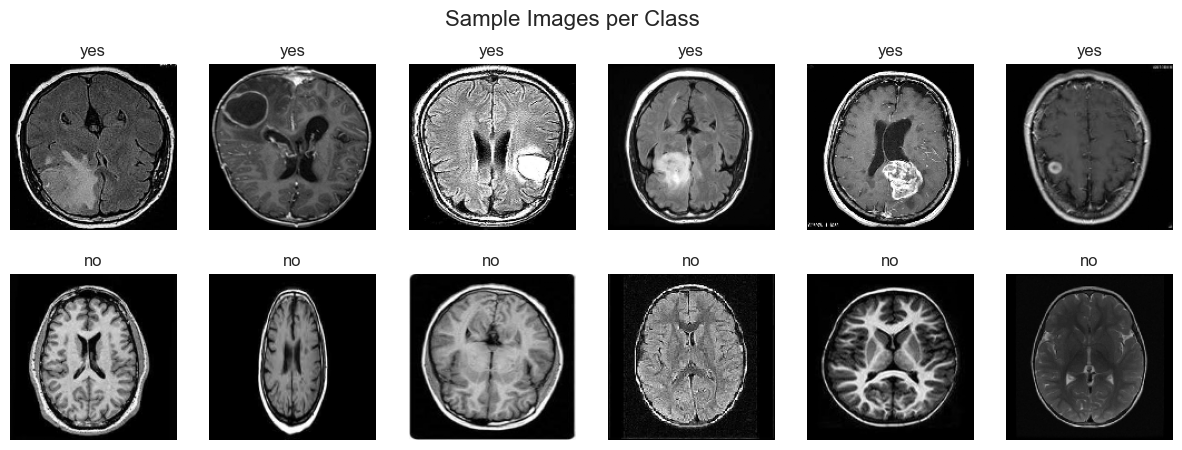

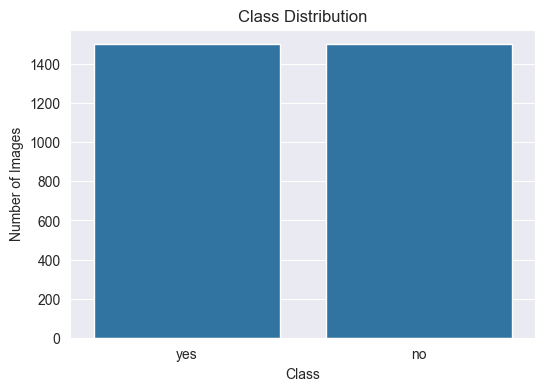

In [34]:
 # step 5: Data visualization

def visualize_samples(data, labels, categories, samples_per_class=6):
    plt.figure(figsize=(15,5))
    for idx, category in enumerate(categories):
        cat_indices = np.where(labels == category)[0]
        cat_indices = np.random.choice(cat_indices, samples_per_class, replace=False)
        for i, img_idx in enumerate(cat_indices):
            plt.subplot(len(categories), samples_per_class, idx*samples_per_class + i + 1)
            plt.imshow(data[img_idx], cmap='gray')
            plt.title(category)
            plt.axis('off')
    plt.suptitle("Sample Images per Class", fontsize=16)
    plt.show()

# Class distribution
def plot_class_distribution(labels, categories):
    labels_series = pd.Series(labels)  # <-- convert to pandas Series
    plt.figure(figsize=(6,4))
    sns.countplot(x=labels_series, order=categories)
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.show()

# Call the functions
visualize_samples(data, labels, categories)
plot_class_distribution(labels, categories)

In [33]:
# step 6 : Prepare labels

le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

#step 7:  CNN
if len(data.shape) == 3:  # (num_samples, H, W)
    data_cnn = np.expand_dims(data, axis=-1)
else:
    data_cnn = data  # já tem canal (RGB)

print(data.shape)

(1724, 224, 224, 3)


In [39]:
# step 8: LSTM/GRU

num_samples = data.shape[0]
# Flatten each image including channels
img_flat = data.reshape(num_samples, -1)  # shape: (num_samples, 224*224*3) = (1724, 150528)

# Decide timesteps for LSTM
timesteps = 32  # 150,528 / 32 = 4,704 features por timestep
total_features = img_flat.shape[1]  # 150,528
features = total_features // timesteps  # 4,704
data_seq = img_flat.reshape(num_samples, timesteps, features)  # (1724, 32, 4704)

features = total_features // timesteps  # 150528 // 25 = 6021
data_seq = img_flat.reshape(num_samples, timesteps, features)  # (1724, 25, 6021)


In [40]:
# step 9: Train / test split

X_train_cnn, X_test_cnn, y_train, y_test = train_test_split(
    data_cnn, labels_categorical, test_size=0.2, random_state=42, stratify=labels_encoded
)

X_train_seq, X_test_seq, _, _ = train_test_split(
    data_seq, labels_categorical, test_size=0.2, random_state=42, stratify=labels_encoded
)

print("CNN input shape:", X_train_cnn.shape)
print("Sequence input shape:", X_train_seq.shape)


CNN input shape: (1379, 224, 224, 3)
Sequence input shape: (1379, 32, 4704)


In [ ]:
 # step 10: CNN Model

 #